In [4]:
# STEP 1: Import Required Libraries
import os
import shutil
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
src_base = '/content/drive/MyDrive/PetImages'


In [5]:
# STEP 2: Prepare Dataset - Copy Clean 6K Images Per Class
src_base = "/content/drive/MyDrive/PetImages"
dst_base = "/content/clean_data"
classes = ['Cat', 'Dog']
max_images = 6000

for cls in classes:
    src_dir = os.path.join(src_base, cls)
    files = [f for f in os.listdir(src_dir) if f.lower().endswith('.jpg')]
    selected = []

    for f in files:
        try:
            img_path = os.path.join(src_dir, f)
            img = Image.open(img_path)
            img.verify()  # Check for corruption
            selected.append(f)
            if len(selected) >= max_images:
                break
        except:
            continue

    train_files, val_files = train_test_split(selected, test_size=0.2, random_state=42)

    for split, file_list in [('train', train_files), ('val', val_files)]:
        split_dir = os.path.join(dst_base, split, cls)
        os.makedirs(split_dir, exist_ok=True)
        for f in file_list:
            shutil.copyfile(os.path.join(src_dir, f), os.path.join(split_dir, f))

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [7]:
from tensorflow.keras import regularizers

img_size = 128
batch_size = 32
input_shape = (img_size, img_size, 3)
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    f"{dst_base}/train",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

val_data = val_gen.flow_from_directory(
    f"{dst_base}/val",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)


Found 9600 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.


In [22]:
from tensorflow.keras import regularizers

model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
dummy_input = np.random.rand(1, img_size, img_size, 3).astype(np.float32)
model.predict(dummy_input)
model.summary()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,665 (12.61 MB)

 Trainable params: 3,305,217 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
#Setup Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)


In [31]:
# Train Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 240ms/step - accuracy: 0.6269 - loss: 0.7801 - val_accuracy: 0.6033 - val_loss: 0.7548 - learning_rate: 0.0010
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 73s 242ms/step - accuracy: 0.6743 - loss: 0.7106 - val_accuracy: 0.7404 - val_loss: 0.6173 - learning_rate: 0.0010
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 238ms/step - accuracy: 0.6912 - loss: 0.6716 - val_accuracy: 0.7317 - val_loss: 0.6293 - learning_rate: 0.0010
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 71s 238ms/step - accuracy: 0.7218 - loss: 0.6468 - val_accuracy: 0.6704 - val_loss: 0.5970 - learning_rate: 0.0010
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 72s 240ms/step - accuracy: 0.7222 - loss: 0.6184 - val_accuracy: 0.6967 - val_loss: 0.6502 - learning_rate: 0.0010
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - accuracy: 0.7175 - loss: 0.6489 - val_accuracy: 0.7725 - val_loss: 0.5464 - learning_rate: 0.0010
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 71s 237ms/step - accuracy: 0.7

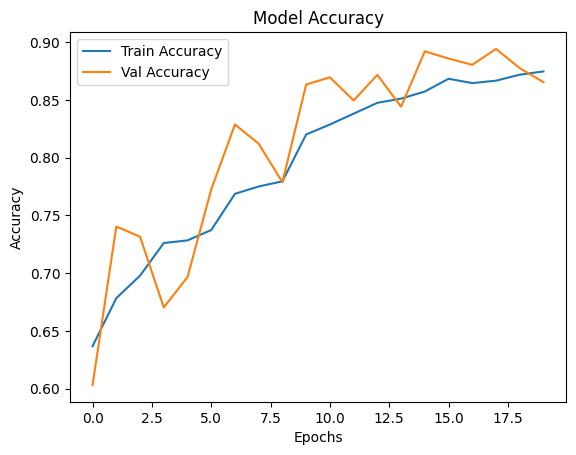

In [32]:
# STEP 8: Plot Results
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


In [33]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\n✅ Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"✅ Final Validation Accuracy: {final_val_acc * 100:.2f}%")



✅ Final Training Accuracy: 87.47%
✅ Final Validation Accuracy: 86.54%


Saving 35.jpg to 35.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Prediction: Cat (Confidence: 0.00)


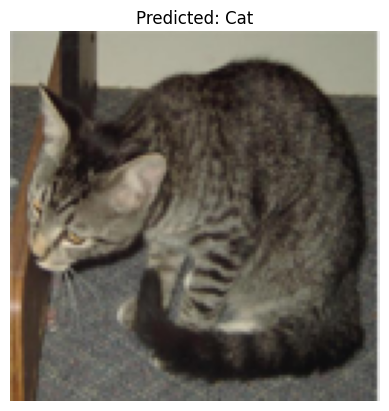

In [41]:
# Re-import in case 'files' was overwritten
from google.colab import files

# Upload image
uploaded = files.upload()

# Loop over uploaded files
for filename in uploaded.keys():
    # Load and preprocess image
    img_path = os.path.join('/content', filename)
    img = Image.open(img_path).convert('RGB')
    img = img.resize((img_size, img_size))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)[0][0]
    label = "Dog" if prediction > 0.5 else "Cat"

    # Show result
    print(f"\nPrediction: {label} (Confidence: {prediction:.2f})")
    plt.imshow(img)
    plt.title(f"Predicted: {label}")
    plt.axis('off')
    plt.show()


In [42]:
!pip install -q gradio


In [43]:
import gradio as gr
from PIL import Image
import numpy as np

def predict_cat_dog(img):
    # Preprocess image
    img = img.convert("RGB")
    img = img.resize((img_size, img_size))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)[0][0]
    label = "Dog 🐶" if prediction > 0.5 else "Cat 🐱"
    confidence = float(prediction) if prediction > 0.5 else 1 - float(prediction)
    return f"{label} (Confidence: {confidence:.2f})"


In [44]:
interface = gr.Interface(
    fn=predict_cat_dog,
    inputs=gr.Image(type="pil", label="Upload an Image"),
    outputs=gr.Label(label="Prediction"),
    title="Cat vs Dog Classifier",
    description="Upload an image of a cat or a dog to get a prediction."
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4840bab1b9c721f780.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
